In [ ]:
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [1]:
import numpy as np
import scipy.io as scio    
import os,re
from scipy import ndimage
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import keras

Using TensorFlow backend.


In [3]:
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D,Concatenate
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau,CSVLogger
from keras import backend as keras

In [33]:
images = np.load('total_images.npy')
gt_labels = np.load('gt_labels_binary.npy')

In [ ]:
print(len(images))
print(len(gt_labels))

In [35]:
train_indices = np.random.choice(2000,1900,replace=False)
print(len(train_indices))

1900


In [36]:
train_images = [images[i] for i in train_indices]
train_labels = [gt_labels[i] for i in train_indices]

In [37]:
print(len(train_images))
print(len(train_labels))

1900
1900


In [38]:
test_indices = [i for i in range(2000) if i not in train_indices]
print(len(test_indices))

100


In [39]:
test_images = [images[i] for i in test_indices]
test_labels = [gt_labels[i] for i in test_indices]

In [40]:
print(len(test_images))
print(len(test_labels))

100
100


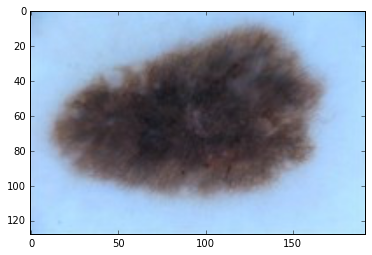

In [41]:
plt.imshow(images[0])
plt.show()

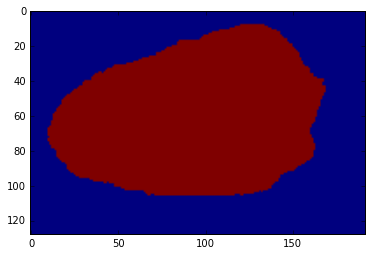

In [42]:
plt.imshow(gt_labels[0])
plt.show()

In [ ]:
print(gt_labels.shape)

In [ ]:
image_dims = images[0].shape
print(image_dims)

In [ ]:
train_mean = np.mean(train_images,axis = (0,1,2,3))
train_std = np.std(train_images,axis = (0,1,2,3))
train_images = (train_images - train_mean)/(train_std+1e-7)

In [ ]:
test_mean = np.mean(test_images,axis=(0,1,2,3))
test_std = np.std(test_images,axis = (0,1,2,3))
test_images = (test_images-test_mean)/(test_std+1e-7)

In [ ]:
train_labels = np.expand_dims(train_labels,axis=3)
test_labels = np.expand_dims(test_labels,axis=3)

In [ ]:
print(train_labels.shape)
print(test_labels.shape)

In [44]:
np.save('train_images.npy',train_images)
np.save('test_images.npy',test_images)
np.save('train_labels.npy',train_labels)
np.save('test_labels.npy',test_labels)

In [43]:
train_images = np.load('train_images.npy')
test_images = np.load('test_images.npy')
train_labels = np.load('train_labels.npy')
test_labels = np.load('test_labels.npy')

In [9]:
train_images[0].shape

(128, 128, 3)

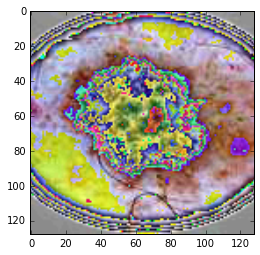

In [10]:
plt.imshow(train_images[0])

In [11]:
test_labels[0].shape

(128, 128, 1)

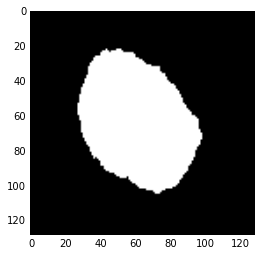

In [12]:
plt.imshow(test_labels[0].reshape((128,128)), cmap = "gray")

In [13]:
def get_unet_model(image_dims):
    inputs = Input((image_dims[0],image_dims[1],image_dims[2]))
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
   

    up6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = Concatenate(axis=3)([conv4,up6])
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3,up7])
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2,up8])
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1,up9])
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  #  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [14]:
model = get_unet_model((128,128,3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
__________

In [15]:
model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('Unet_lr_e4_bs_10.csv')
model_checkpoint = ModelCheckpoint("Unet_lr_e4_bs_10.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [17]:
model.fit(train_images, train_labels, batch_size=4, epochs=25, verbose=1,validation_data=(test_images,test_labels), shuffle=True, callbacks=[lr_reducer,csv_logger,model_checkpoint])

Train on 1900 samples, validate on 100 samples
Epoch 1/25
1900/1900 [==============================] - 142s - loss: 0.3549 - acc: 0.8658 - val_loss: 0.2448 - val_acc: 0.9093
Epoch 2/25
1900/1900 [==============================] - 137s - loss: 0.2010 - acc: 0.9266 - val_loss: 0.1520 - val_acc: 0.9446
Epoch 3/25
1900/1900 [==============================] - 137s - loss: 0.1679 - acc: 0.9378 - val_loss: 0.2079 - val_acc: 0.9223
Epoch 4/25
1900/1900 [==============================] - 137s - loss: 0.1624 - acc: 0.9394 - val_loss: 0.1402 - val_acc: 0.9460
Epoch 5/25
1900/1900 [==============================] - 139s - loss: 0.1407 - acc: 0.9467 - val_loss: 0.1473 - val_acc: 0.9451
Epoch 6/25
1900/1900 [==============================] - 137s - loss: 0.1482 - acc: 0.9448 - val_loss: 0.1310 - val_acc: 0.9483
Epoch 7/25
1900/1900 [==============================] - 140s - loss: 0.1318 - acc: 0.9503 - val_loss: 0.1559 - val_acc: 0.9428
Epoch 8/25
1900/1900 [==============================] - 140s - l

In [18]:
model.load_weights('Unet_lr_e4_bs_10.hdf5')

In [19]:
train_images.shape

(1900, 128, 128, 3)

In [20]:
test_images = np.expand_dims(test_images,axis=1)

In [21]:
sample  = train_images[0]
sample = sample.reshape(1,128,128,3)

In [22]:
predictions = model.predict(test_images[5].reshape((1,128,128,3)))

In [23]:
predictions.shape

(1, 128, 128, 1)

In [28]:
predictions = predictions.reshape((128,128))

In [29]:
results = predictions > 0.5

In [30]:
results.shape

(128, 128)

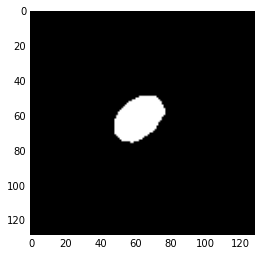

In [31]:
plt.imshow(results, cmap = "gray")